# RNN with LSTM for japanese character classification

In [8]:
import time
import math

import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from utils import load_data, file_to_tensor, character_to_tensor, random_training_example

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define network structure

In [3]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_layers, n_characters):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, n_characters)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        
        # output of shape (seq_len, batch, n_directions * hidden_size)
        out, _ = self.lstm(x, (h0,c0))
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)

        return out

## Define helper functinos for neural network's training

In [4]:
def train(file_tensor, character_tensor):
    output = model(file_tensor)
    loss = criterion(output, character_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def character_from_output(output):
    character_idx = torch.argmax(output).item()
    return all_characters[character_idx]

## Defining hyperparameters of neural network's training

In [17]:
# load train dataset
character_files, all_characters = load_data(subfolder="train")

# hyper parameters
input_size = 3 # features: x_acc, y_acc, z_acc
n_characters = len(all_characters) # output_size
hidden_size = 128
n_layers = 1

learning_rate = 0.005

## Start training loop

In [18]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_layers, n_characters).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 500
plot_every = 100
n_iters = 10000

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for i in range(1, n_iters + 1):
    character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    output, loss = train(file_tensor.to(device), character_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = character_from_output(output)
        correct = '✓' if guess == character else '✗ (%s)' % character
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 5% (1m 42s) 1.7020 data/train\a__55697.csv / u ✗ (a)
1000 10% (3m 19s) 1.6599 data/train\a__99708.csv / u ✗ (a)
1500 15% (4m 56s) 1.4975 data/train\u__42376.csv / u ✓
2000 20% (6m 32s) 1.5212 data/train\u__45378.csv / u ✓
2500 25% (8m 11s) 1.4848 data/train\e__12853.csv / e ✓
3000 30% (9m 48s) 1.6311 data/train\i__54477.csv / u ✗ (i)
3500 35% (11m 25s) 1.3426 data/train\e__30746.csv / e ✓
4000 40% (13m 0s) 1.5380 data/train\i__12393.csv / e ✗ (i)
4500 45% (14m 31s) 1.4765 data/train\i__44481.csv / u ✗ (i)
5000 50% (16m 1s) 1.3560 data/train\u__56673.csv / u ✓
5500 55% (16m 59s) 1.4268 data/train\a__85026.csv / e ✗ (a)
6000 60% (17m 59s) 0.9805 data/train\u__35261.csv / u ✓
6500 65% (19m 6s) 0.9590 data/train\u__89555.csv / u ✓
7000 70% (20m 35s) 1.3779 data/train\u__74597.csv / o ✗ (u)
7500 75% (22m 3s) 1.1857 data/train\i__13846.csv / i ✓
8000 80% (23m 30s) 1.2702 data/train\u__47583.csv / o ✗ (u)
8500 85% (24m 57s) 0.0260 data/train\e__32221.csv / e ✓
9000 90% (26m 29s) 1.0592 da

## Plot LOSS-function

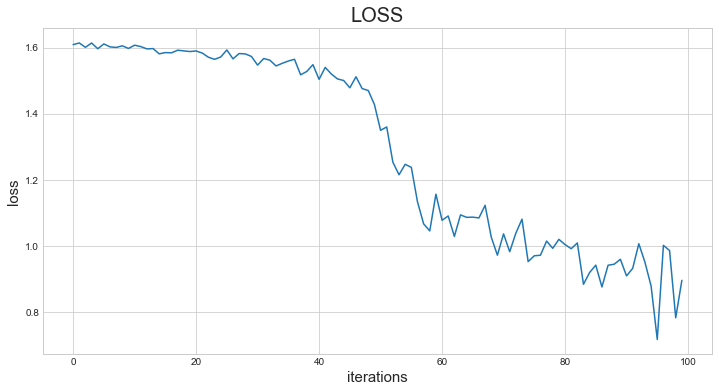

In [19]:
# create figure
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [22]:
FILE = "main_lstm.pth"
torch.save(model.state_dict(), FILE)

## Load model

In [ ]:
loaded_model = RNN(n_features, hidden_size, n_characters)
loaded_model.load_state_dict(torch.load(FILE))
loaded_model.eval()

## Determine accuracy

In [21]:
# load test dataset
character_files, all_characters = load_data(subfolder="test")

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for character in all_characters:
        # all files from one character
        for file in character_files[character]:
            file_tensor = file_to_tensor(file).to(device)
            # get output
            output = model(file_tensor)
            # get character from output
            guess = character_from_output(output)
            n_samples += 1
            if guess == character:
                n_correct += 1
    
    acc = 100.0 * n_correct / n_samples
    print(f"accuracy = {acc:.2f} %")

accuracy = 57.69 %
